In [58]:
from netCDF4 import Dataset
from numpy import meshgrid
import numpy as np
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline
matplotlib.rcParams['legend.handlelength'] = 0

In [59]:
nc=Dataset('all_stac.nc')

In [60]:
nc.variables
lon=nc['longitude'][:]
lat=nc['latitude'][:]
v10=nc['v10'][:]
u10=nc['u10'][:]
time=nc['time'][:]

In [61]:
months=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
date=[]
for year in range(1979,2009):
    for month in range (1,13):
        k=months[month-1]+1
        if year%4==0 and month==2:
            k=k+1
        for day in range(1,k):
            for h in range(1,5):
                wy=year
                wm=month
                wd=day
                wh=h*6%24
                if h==4:
                    wd=day+1
                    wh=0
                    if wd>months[month-1]:
                        wd=1
                        wm=month+1
                        if wm>12:
                            wy=year+1
                            wd=1
                            wm=1
                date.append(str(wy)+' '+str(wm)+' '+str(wd)+' '+str(wh))

In [62]:
m1=[]
m2=[]
m3=[]
m4=[]
m5=[]
m6=[]
m7=[]
m8=[]
m9=[]
m10=[]
m11=[]
m12=[]

for i in range(len(date)):
    ln=date[i]
    mes=int(ln[5])
    #print(mes)
    if mes==1 and ln[6]==' ':
        m1.append(i)
    if mes==2:
        m2.append(i)
    if mes==3:
        m3.append(i)
    if mes==4:
        m4.append(i)
    if mes==5:
        m5.append(i)
    if mes==6:
        m6.append(i)
    if mes==7:
        m7.append(i)
    if mes==8:
        m8.append(i)
    if mes==9:
        m9.append(i)
    if mes==1 and ln[6]!=' ' and int(ln[6])==0:
        m10.append(i)
    if mes==1 and ln[6]!=' ' and int(ln[6])==1:
        m11.append(i)
    if mes==1 and ln[6]!=' ' and int(ln[6])==2:
        m12.append(i)
print('OK')

OK


In [63]:
nc=Dataset('C:\Users\Lina1\Documents\Python Scripts\Work_scripts\mask.nc')
x=nc.variables['longitude'][:]
y=nc.variables['latitude'][:]
print(len(x),len(y))
mask=nc.variables['lsm'][0,:,:]

(14, 17)


In [64]:
#одна минута - 0,0166667 градуса
#одна секунда - 0,000277778 градуса
def min_sec(ind,deg,minut,sec):
    if ind==1:
        return minut*0.0166667+sec*0.000277778+deg
    else:
        return deg+0.01*minut
    

In [65]:
glob=[m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12]

In [66]:
def search(latitude,lat):
    l=[abs(x-latitude) for x in lat ]
    p=[abs(x-latitude) for x in lat ]
    #list(l)
    a=min(l)
    i=list.index(l,a)
    l.remove(a)
    a=min(l)
    j=list.index(p,a)
    return(i,j)

In [67]:
def final_search(dex,mi1,s1,d1,mi2,s2,d2):
    mas=[]
    x1=[]
    y1=[]
    for i in range(2):
        for k in range(2):
            x=lat[search(min_sec(dex,mi1,s1,d1),lat)[i]]
            y=lon[search(min_sec(dex,mi2,s2,d2),lon)[k]]
            mas.append(np.sqrt((x-min_sec(dex,mi1,s1,d1))**2+(y-min_sec(dex,mi2,s2,d2))**2))
            x1.append(i)
            y1.append(k)
   # print(x1,y1,mas)
    return(x1,y1,mas)

In [154]:
def total(dex,d1,mi1,s1,d2,mi2,s2,name):
    year_hod=[]
    #print(min_sec(mi1,s1,d1),min_sec(mi2,s2,d2))
    x,y,z=final_search(dex,d1,mi1,s1,d2,mi2,s2)
    k=len(x)
    i=0
    l=0
    for i in range(len(x)):
        if mask[x[i]][y[i]]==0:
            l=1
    
    while k!=0 and l==1:
        k-=1
        if mask[x[i]][y[i]]!=0:
            print(mask[x[i]][y[i]])
            x.pop(i)
            y.pop(i)
            z.pop(i)
        else:
            i+=1 
  
    wind_t1=[]
    #print(wind_t1)
    for j in range(len(x)):
        wind=[]
        for i in range(len(glob)):
                sum1_1=0
                for k in glob[i]:
                    wind1=np.sqrt(v10[k,x[j],y[j]]**2+u10[k,x[j],y[j]]**2)
                    sum1_1+=wind1
                wind.append(sum1_1/len(glob[i]))
        wind_t1.append(wind)
    #wind_t1=np.array(wind_t1)
    #print(wind_t1)
    for i in range(12):
        z1=[l[i] for l in wind_t1]
        if len(x)>=2:
            lr2 = LinearRegression()
            df=pd.DataFrame({'x':[lat[i] for i in x],'y':[lon[i] for i in y],'z1':z1})
            print(df)
            lr2.fit(df[['x','y']],df.z1)
            l3=[min_sec(dex,d1,mi1,s1),min_sec(dex,d2,mi2,s2)]
            print(l3)
            y3 = lr2.predict([l3])
            print(y3)
            year_hod.append(y3)
        else: #and mask[x1][y1]==1:
            year_hod=wind_t1
            #else:
               # year_hod.append(sum_0*(mask[x1][y1]+1)%2+sum_1*(mask[x2][y2]+1)%2)
    print(year_hod)    
    path=name+'.txt'
    f=open(path,'w')
    for i in year_hod:
        f.write(str(i)+'\n')
    f.close()
    #year_hod.append(y2)
    return(year_hod)

C:\Users\Lina1\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


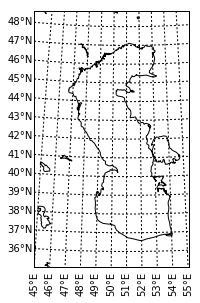

In [69]:
from mpl_toolkits.basemap import Basemap
fig=plt.figure(figsize=(6.29921,4.72441))
#axes = pylab.gca()
#axes.set_aspect(0,0,12,9)
map1 = Basemap(llcrnrlon=45.,llcrnrlat=35.,urcrnrlon=56.,urcrnrlat=48.75,
             resolution='i', projection='tmerc', lat_0 = 42, lon_0 = 51)
map1.drawmapboundary()
#map.fillcontinents(color='blue',lake_color='white')
map1.drawcoastlines()
map1.drawmeridians(np.arange(45,56,1),labels=[0,0,0,1],rotation=90)
map1.drawparallels(np.arange(36,48.75,1),labels=[1,0,0,0])
plt.show()
from PIL import Image
img = Image.open('kaspiy_square.png')
img.show()

<img src="kaspiy_square.png">

In [155]:
#Северо-Западное побережье
one=total(1,45,43,4,47,34,45,"Biruchya_kosa")#Бирючья коса
two=total(1,42,30,0,47,29,0,"Mahachkala")#Махачкала
four=total(0,42,75,0,47,75,0,"Square_21")#кв.21
three=total(0,43,50,0,47,75,0,"Square_16")#кв.16


       x      y        z1
0  48.00  45.75  5.548373
1  48.00  46.50  5.632128
2  47.25  45.75  5.485866
3  47.25  46.50  5.436120
[45.717779212, 47.57916781]
[ 5.22989421]
       x      y        z1
0  48.00  45.75  5.720668
1  48.00  46.50  5.792999
2  47.25  45.75  5.646739
3  47.25  46.50  5.594569
[45.717779212, 47.57916781]
[ 5.36198981]
       x      y        z1
0  48.00  45.75  5.532152
1  48.00  46.50  5.592918
2  47.25  45.75  5.507018
3  47.25  46.50  5.468456
[45.717779212, 47.57916781]
[ 5.35645228]
       x      y        z1
0  48.00  45.75  5.093871
1  48.00  46.50  5.220571
2  47.25  45.75  5.137116
3  47.25  46.50  5.173237
[45.717779212, 47.57916781]
[ 5.30884669]
       x      y        z1
0  48.00  45.75  4.635447
1  48.00  46.50  4.728069
2  47.25  45.75  4.758475
3  47.25  46.50  4.767547
[45.717779212, 47.57916781]
[ 5.02759536]
       x      y        z1
0  48.00  45.75  4.293620
1  48.00  46.50  4.365872
2  47.25  45.75  4.407912
3  47.25  46.50  4.398111
[45.717779

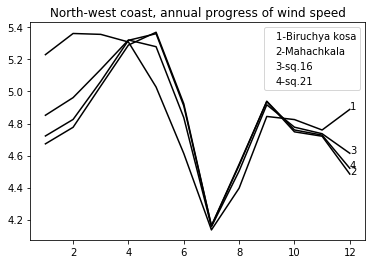

In [156]:
font = {'family' : 'normal',
        'weight' : 'normal',
       'size'   : 12}
fig1=plt.figure(figsize=(6,4))
godiki=np.arange(1,13,1)
plt.plot(godiki,one,'black',label="1")
plt.text(12, one[11], '1')
plt.plot(godiki,two,'black',label="2")
plt.text(12, two[11], '2')
plt.plot(godiki,three,'black',label="3")
plt.text(12, three[11], '3')
plt.plot(godiki,four,'black',label="4")
plt.text(12, four[11], '4')
plt.legend(("1-Biruchya kosa", "2-Mahachkala", "3-sq.16","4-sq.21"))
plt.title("North-west coast, annual progress of wind speed")
#plt.show()
plt.savefig("Wind_north_west.jpg",format="jpg")

In [157]:
#Район Дербент - Низовая пристань
five=total(0,42,6.7,0,48,30,0,"Derbent")#Бирючья коса 42,067	48,3
six=total(1,41,31,7,48,54,51,"Nizovaya_Pristan")#Низовая пристань

       x      y        z1
0  48.00  45.75  5.548373
1  48.00  46.50  5.632128
2  47.25  45.75  5.485866
3  47.25  46.50  5.436120
[42.067, 48.3]
[ 4.61704923]
       x      y        z1
0  48.00  45.75  5.720668
1  48.00  46.50  5.792999
2  47.25  45.75  5.646739
3  47.25  46.50  5.594569
[42.067, 48.3]
[ 4.70879716]
       x      y        z1
0  48.00  45.75  5.532152
1  48.00  46.50  5.592918
2  47.25  45.75  5.507018
3  47.25  46.50  5.468456
[42.067, 48.3]
[ 5.00302622]
       x      y        z1
0  48.00  45.75  5.093871
1  48.00  46.50  5.220571
2  47.25  45.75  5.137116
3  47.25  46.50  5.173237
[42.067, 48.3]
[ 5.37713931]
       x      y        z1
0  48.00  45.75  4.635447
1  48.00  46.50  4.728069
2  47.25  45.75  4.758475
3  47.25  46.50  4.767547
[42.067, 48.3]
[ 5.47198147]
       x      y        z1
0  48.00  45.75  4.293620
1  48.00  46.50  4.365872
2  47.25  45.75  4.407912
3  47.25  46.50  4.398111
[42.067, 48.3]
[ 4.99988259]
       x      y        z1
0  48.00  45.75  4.0

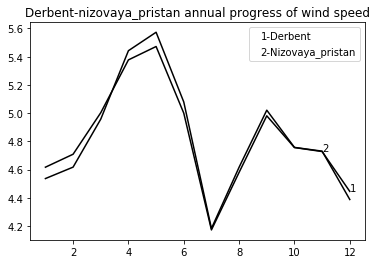

In [158]:
font = {'family' : 'normal',
        'weight' : 'normal',
       'size'   : 12}
fig1=plt.figure(figsize=(6,4))
godiki=np.arange(1,13,1)
plt.plot(godiki,five,'black',label="1")
plt.text(12, five[11], '1')
plt.plot(godiki,six,'black',label="2")
plt.text(11, six[10], '2')
plt.legend(("1-Derbent","2-Nizovaya_pristan"))
plt.title("Derbent-nizovaya_pristan annual progress of wind speed")
#plt.show()
plt.savefig("Derbent_niz_wind.png",format="png")

In [159]:
#Апшеронский порог
seven=total(0,40,75,0,50,50,0,"square_34")#Квадрат 34
eight=total(0,40,20,0,50,90,0,"Neftyanie_kamni")#Нефтяные камни 40,2	50,9
nine=total(0,40,50,0,51,75,0,"square_36")#Квадрат 36


       x      y        z1
0  48.00  45.75  5.548373
1  48.00  46.50  5.632128
2  47.25  45.75  5.485866
3  47.25  46.50  5.436120
[40.75, 50.5]
[ 4.43995212]
       x      y        z1
0  48.00  45.75  5.720668
1  48.00  46.50  5.792999
2  47.25  45.75  5.646739
3  47.25  46.50  5.594569
[40.75, 50.5]
[ 4.49923554]
       x      y        z1
0  48.00  45.75  5.532152
1  48.00  46.50  5.592918
2  47.25  45.75  5.507018
3  47.25  46.50  5.468456
[40.75, 50.5]
[ 4.90424585]
       x      y        z1
0  48.00  45.75  5.093871
1  48.00  46.50  5.220571
2  47.25  45.75  5.137116
3  47.25  46.50  5.173237
[40.75, 50.5]
[ 5.61235464]
       x      y        z1
0  48.00  45.75  4.635447
1  48.00  46.50  4.728069
2  47.25  45.75  4.758475
3  47.25  46.50  4.767547
[40.75, 50.5]
[ 5.76381402]
       x      y        z1
0  48.00  45.75  4.293620
1  48.00  46.50  4.365872
2  47.25  45.75  4.407912
3  47.25  46.50  4.398111
[40.75, 50.5]
[ 5.2201331]
       x      y        z1
0  48.00  45.75  4.078966
1

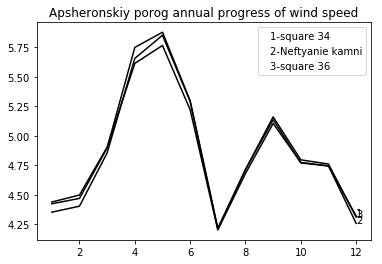

In [160]:
font = {'family' : 'normal',
        'weight' : 'normal',
       'size'   : 12}
fig1=plt.figure(figsize=(6,4))
godiki=np.arange(1,13,1)
plt.plot(godiki,seven,'black',label="1")
plt.text(12, seven[11], '1')
plt.plot(godiki,eight,'black',label="2")
plt.text(12, eight[11], '2')
plt.plot(godiki,nine,'black',label="3")
plt.text(12, nine[11], '3')
plt.legend(("1-square 34","2-Neftyanie kamni","3-square 36"))
plt.title("Apsheronskiy porog annual progress of wind speed")
#plt.show()
plt.savefig("Apsh_porog_wind.png",format="png")

In [163]:
seven=total(0,40,75,0,50,50,0,"square_34")#Квадрат 34
eight=total(1,40,14,57,50,50,34,"Neftyanie_kamni")#Нефтяные камни 40,2	50,9
nine=total(0,40,50,0,51,75,0,"square_36")#Квадрат 36

lat  lon  res
0    1    2    3
1    4    5    6

In [161]:
#Западная часть акватории
ten=total(0,39,50,0,49,50,0,"square_38")#квадрат 38
eleven=total(0,38,50,0,49,50,0,"square_43")#квадрат 43


       x      y        z1
0  48.00  45.75  5.548373
1  48.00  46.50  5.632128
2  47.25  45.75  5.485866
3  47.25  46.50  5.436120
[39.5, 49.5]
[ 4.2018504]
       x      y        z1
0  48.00  45.75  5.720668
1  48.00  46.50  5.792999
2  47.25  45.75  5.646739
3  47.25  46.50  5.594569
[39.5, 49.5]
[ 4.2588293]
       x      y        z1
0  48.00  45.75  5.532152
1  48.00  46.50  5.592918
2  47.25  45.75  5.507018
3  47.25  46.50  5.468456
[39.5, 49.5]
[ 4.76477951]
       x      y        z1
0  48.00  45.75  5.093871
1  48.00  46.50  5.220571
2  47.25  45.75  5.137116
3  47.25  46.50  5.173237
[39.5, 49.5]
[ 5.50039908]
       x      y        z1
0  48.00  45.75  4.635447
1  48.00  46.50  4.728069
2  47.25  45.75  4.758475
3  47.25  46.50  4.767547
[39.5, 49.5]
[ 5.83143949]
       x      y        z1
0  48.00  45.75  4.293620
1  48.00  46.50  4.365872
2  47.25  45.75  4.407912
3  47.25  46.50  4.398111
[39.5, 49.5]
[ 5.30060861]
       x      y        z1
0  48.00  45.75  4.078966
1  48.00

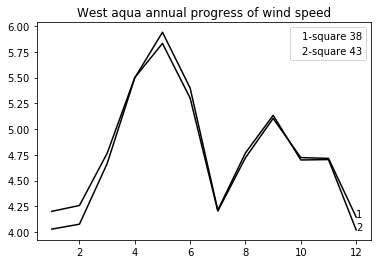

In [162]:
fig1=plt.figure(figsize=(6,4))
godiki=np.arange(1,13,1)
plt.plot(godiki,ten,'black',label="1")
plt.text(12, ten[11], '1')
plt.plot(godiki,eleven,'black',label="2")
plt.text(12, eleven[11], '2')
plt.legend(("1-square 38","2-square 43"))
plt.title("West aqua annual progress of wind speed")
#plt.show()
plt.savefig("west_aqua_wind.png",format="png")

In [19]:
#Кара_Богаз_Гол
twelwe=total(0,40,20,0,52,70,0,"kuuli_mayak")#Куули_маяк
thirteen=total(0,39,40,0,53,10,0,"Cheleken")#Челекен


(40.5, 52.5, 39.75, 52.5)
(10, 9, 11, 9)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
[array([ 5.74998216]), array([ 5.6718211]), array([ 5.38126604]), array([ 4.8920338]), array([ 4.77957927]), array([ 5.44503215]), array([ 5.44094323]), array([ 5.66794799]), array([ 5.6819837]), array([ 5.41898338]), array([ 5.73603403]), array([ 5.86878216])]
(39.75, 53.25, 39.0, 53.25)
(11, 10, 12, 10)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
[array([ 5.00946528]), array([ 4.89877979]), array([ 4.71290754]), array([ 4.47724234]), array([ 4.46391456]), array([ 4.92016239]), array([ 4.74181424]), array([ 5.01847578]), array([ 5.13477628]), array([ 4.94719962]), array([ 5.03814653]), array([ 5.18110531])]


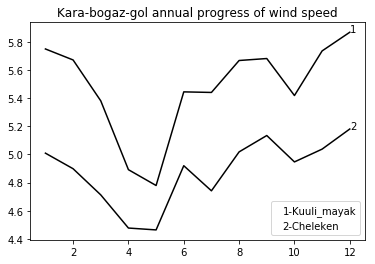

In [20]:
fig1=plt.figure(figsize=(6,4))
godiki=np.arange(1,13,1)
plt.plot(godiki,twelwe,'black',label="1")
plt.text(12, twelwe[11], '1')
plt.plot(godiki,thirteen,'black',label="2")
plt.text(12, thirteen[11], '2')
plt.legend(("1-Kuuli_mayak","2-Cheleken"))
plt.title("Kara-bogaz-gol annual progress of wind speed")
#plt.show()
plt.savefig("Kara_bogaz_wind.png",format="png")

In [26]:
h1,h2,h3=final_search(0,40,20,0,52,70,0)

C:\Users\Lina1\Anaconda2\lib\site-packages\scipy\interpolate\interpolate.py:414: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind in ['zero', 'slinear', 'quadratic', 'cubic']:
C:\Users\Lina1\Anaconda2\lib\site-packages\scipy\interpolate\interpolate.py:421: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif kind not in ('linear', 'nearest'):


NotImplementedError: [   0.            0.68587106    5.48696845   18.51851852   43.8957476
   85.73388203  148.14814815  235.25377229  351.1659808   500.        ] is unsupported: Use fitpack routines for other types.

In [31]:
hui=[1,2,3]
hui.append(0)
k=4
i=0
while k!=0:
    k-=1
    if hui[i]>=2:
        hui.pop(i)
    else:
        i+=1
hui

[1, 0]

In [126]:
one=total(1,45,43,4,47,34,45,"Biruchya_kosa")

<type 'list'>
([0, 0, 1, 1], [0, 1, 0, 1], [0.33074102606047784, 0.4220638711374568, 0.78965716885211834, 0.83204971565378294])
(4, 4, 4)
[[ 5.54837306  5.72066805  5.53215228  5.09387091  4.63544661  4.29361974
   4.07896584  4.2366112   4.68902693  4.81589431  4.73250587  5.10402668]
 [ 5.63212816  5.79299879  5.59291839  5.22057147  4.72806928  4.36587159
   4.12813339  4.29023679  4.75101993  4.87446912  4.79646408  5.18957546]
 [ 5.48586627  5.64673896  5.50701822  5.13711594  4.7584751   4.40791175
   4.12721251  4.31210754  4.74471136  4.84044385  4.77655383  5.08230451]
 [ 5.43611974  5.59456914  5.46845583  5.17323735  4.76754703  4.39811141
   4.09217295  4.28510647  4.74022154  4.81520553  4.73495782  5.02397442]]
[ 5.54837306  5.63212816  5.48586627  5.43611974]
   x  y         z
0  0  0  5.548373
1  0  1  5.632128
2  1  0  5.485866
3  1  1  5.436120


ValueError: Found input variables with inconsistent numbers of samples: [2, 4]

In [122]:
two=total(1,42,30,0,47,29,0,"Mahachkala")

<type 'list'>
([0, 0, 1, 1], [0, 1, 0, 1], [0.34197133733325158, 0.57397120620941289, 0.55176616021416969, 0.71898848777813162])
(4, 4, 4)
[[ 5.54837306  5.72066805  5.53215228  5.09387091  4.63544661  4.29361974
   4.07896584  4.2366112   4.68902693  4.81589431  4.73250587  5.10402668]
 [ 5.63212816  5.79299879  5.59291839  5.22057147  4.72806928  4.36587159
   4.12813339  4.29023679  4.75101993  4.87446912  4.79646408  5.18957546]
 [ 5.48586627  5.64673896  5.50701822  5.13711594  4.7584751   4.40791175
   4.12721251  4.31210754  4.74471136  4.84044385  4.77655383  5.08230451]
 [ 5.43611974  5.59456914  5.46845583  5.17323735  4.76754703  4.39811141
   4.09217295  4.28510647  4.74022154  4.81520553  4.73495782  5.02397442]]
[ 5.54837306  5.63212816  5.48586627  5.43611974]


ValueError: Found input variables with inconsistent numbers of samples: [2, 4]

In [93]:
pl=np.array([[1,2],[3,4]])
pl[:,0]

array([1, 3])

In [109]:
hui1=[1,2]
hui2=[3,4]
huidf=pd.DataFrame([np.array(hui1).T,np.array(hui2).T])
huidf

0  1
0  1  2
1  3  4